In [3]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
crawford_resnet50_path = kagglehub.dataset_download('crawford/resnet50')
quddusikashaf_eyepacs_dataset_for_ml_path = kagglehub.dataset_download('quddusikashaf/eyepacs-dataset-for-ml')

print('Data source import complete.')


100%|██████████| 174M/174M [00:01<00:00, 110MB/s]

Extracting files...


100%|██████████| 0.98G/0.98G [00:04<00:00, 220MB/s]

Extracting files...


Data source import complete.


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [12]:
import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Set path to the dataset
from google.colab import drive
drive.mount('/content/drive')
dataset_path = "/content/drive/My Drive/eyepac"
# Initialize ImageDataGenerator for augmenting and normalizing images
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Load images into the generator
train_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),  # Resize images
    batch_size=32,
    class_mode='binary',  # or 'categorical' depending on your labels
    subset='training'
)

valid_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',  # or 'categorical'
    subset='validation'
)


test_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',  # or 'categorical'
    subset='validation'
)

# Optional: Split your dataset into training and testing if not using flow_from_directory
# This assumes you already have a structured set of images.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 4808 images belonging to 3 classes.
Found 1201 images belonging to 3 classes.
Found 1201 images belonging to 3 classes.


In [6]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50


# Load the pre-trained EfficientNetB7 model
#pretrained_weights_path = '/kaggle/input/pretrained-efficientnetb7/efficientnetb7_notop.h5'
#base_model = EfficientNetB7(weights=pretrained_weights_path if os.path.exists(pretrained_weights_path) else None, include_top=False, input_shape=(128, 128, 3))


pretrained_weights_path = "/kaggle/input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels.h5"
# pretrained_weights_path = C:\Users\laksh\Downloads\resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Load the ResNet50 model, excluding the top layers (we'll add our own classifier)
base_model = ResNet50(weights=pretrained_weights_path if os.path.exists(pretrained_weights_path) else "imagenet", include_top=False, input_shape=(224, 224, 3))
# base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers to avoid training them initially
base_model.trainable = False

# Build the complete model with additional layers
model = models.Sequential([
    base_model,  # Pre-trained layers from ResNet50
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Sigmoid for binary classification (Healthy vs Diabetic)
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Show the model summary
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,686,913 (97.99 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [31]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    "/content/drive/My Drive/diabetic_retinopathy_best_model.keras",
    save_best_only=True,
    save_weights_only=False,
    monitor="val_loss",
    mode="min",
    verbose=1
)


In [32]:
model.save("/content/drive/My Drive/diabetic_retinopathy_model.keras")


In [33]:
# Train the model
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=25,
    verbose=1,
    callbacks=[checkpoint]
)

# Evaluate the model
evaluation = model.evaluate(valid_gen)
print(f"Validation Loss: {evaluation[0]}, Validation Accuracy: {evaluation[1]}")

# Save the trained model
model_save_path = "/content/drive/My Drive/diabetic_retinopathy_model.h5"
model.save(model_save_path)
print(f"Model saved at {model_save_path}")


Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.7087 - loss: -62268.9609
Epoch 1: val_loss improved from inf to -64933.22266, saving model to /content/drive/My Drive/diabetic_retinopathy_best_model.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 70s 454ms/step - accuracy: 0.7086 - loss: -62274.7695 - val_accuracy: 0.6994 - val_loss: -64933.2227
Epoch 2/25
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.7002 - loss: -68327.1406
Epoch 2: val_loss improved from -64933.22266 to -69399.89062, saving model to /content/drive/My Drive/diabetic_retinopathy_best_model.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 76s 416ms/step - accuracy: 0.7002 - loss: -68322.2109 - val_accuracy: 0.6994 - val_loss: -69399.8906
Epoch 3/25
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.7021 - loss: -73381.6328
Epoch 3: val_loss improved from -69399.89062 to -74105.32812, saving model to /content/drive/My Drive/diabetic_retinopathy_best_model.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 91s 474ms/step - accuracy: 0.702

Validation Loss: -203660.90625, Validation Accuracy: 0.6994171738624573
Model saved at /content/drive/My Drive/diabetic_retinopathy_model.h5


In [34]:
# Evaluate the model
evaluation = model.evaluate(valid_gen)
print(f"Validation Loss: {evaluation[0]}, Validation Accuracy: {evaluation[1]}")

# Save the trained model
model_save_path = "/content/drive/My Drive/diabetic_retinopathy_model.h5"
model.save(model_save_path)
print(f"Model saved at {model_save_path}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 332ms/step - accuracy: 0.6996 - loss: -251483.7344


Validation Loss: -203660.875, Validation Accuracy: 0.6994171738624573
Model saved at /content/drive/My Drive/diabetic_retinopathy_model.h5


In [35]:
# Grad-CAM visualization for lesion-based interpretation
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import numpy as np
import cv2

def grad_cam(input_model, image, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        inputs=[input_model.inputs],
        outputs=[input_model.get_layer(last_conv_layer_name).output, input_model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [36]:
import matplotlib.pyplot as plt

In [37]:
def display_training_curves(training, validation, title, subplot):

    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

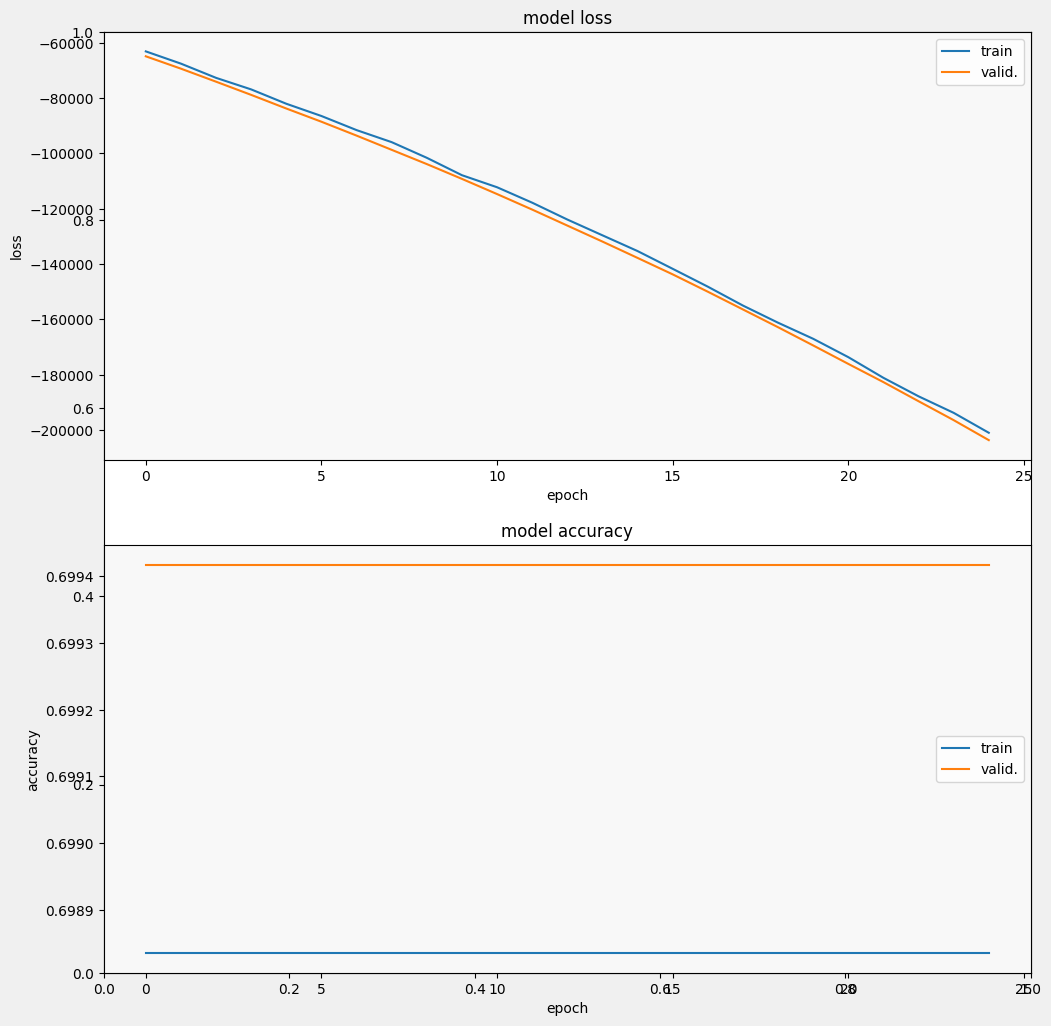

In [38]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss', 211)
display_training_curves(
    history.history['accuracy'],
    history.history['val_accuracy'],
    'accuracy', 212)

In [39]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 335ms/step - accuracy: 0.6969 - loss: -197844.2031
Test Accuracy: 69.94%


In [42]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
# Get predictions for the test data
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels for the test data
y_true = test_gen.classes

38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 324ms/step


In [44]:
cm = confusion_matrix(y_true, y_pred_classes)

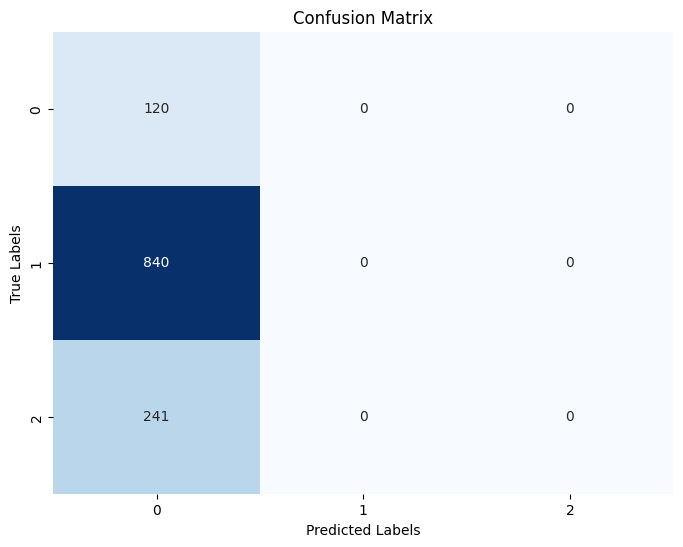

In [45]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()